# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [27]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

print(f"Using Cantera version {ct.__version__}")

Using Cantera version 2.5.1


## Cantera Simulation Procedure

In all Cantera simulations, there are three main steps:

1. Create the phase object from an input file
2. Set the initial/boundary conditions
3. Run the simulation

In the case of a batch reactor, Cantera includes several built-in reactor models to calculate the energy and species equations subject to either constant volume or constant pressure conditions.

### Define the gas

First, we have to define the phase.

In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [28]:
# Define the gas mixture and kinetics
gas = ct.Solution('data/seiser.yaml')
gas()

For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391.0
	Value computed using low-temperature polynomial:  21.83428060093267
	Value computed using high-temperature polynomial: 21.76699500201913


  gas:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   1.138 kg/m^3
  mean mol. weight   28.014 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy              1971             55214  J
   internal energy            -87068       -2.4391e+06  J
           entropy            6842.7        1.9169e+05  J/K
    Gibbs function       -2.0508e+06       -5.7452e+07  J
 heat capacity c_p            1037.9             29075  J/K
 heat capacity c_v            741.09             20761  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             

### Define reactor conditions: temperature, pressure, fuel, stoichiometry

Next, we need to define initial conditions. We will choose a temperature of 1000 K, pressure of 1 atm, and equivalence ratio of 1.0. Remember to set the composition before the temperature and pressure.

In [29]:
reactor_temperature = 1000 # Kelvin
reactor_pressure = 101325 # Pascals

gas.set_equivalence_ratio(phi=1.0, fuel="nc7h16", oxidizer={"o2": 1.0, "n2": 3.76})
gas.TP = reactor_temperature, reactor_pressure

gas()


  gas:

       temperature   1000 K
          pressure   1.0132e+05 Pa
           density   0.36789 kg/m^3
  mean mol. weight   30.188 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        7.1647e+05        2.1629e+07  J
   internal energy        4.4105e+05        1.3314e+07  J
           entropy              8152        2.4609e+05  J/K
    Gibbs function       -7.4355e+06       -2.2447e+08  J
 heat capacity c_p            1316.7             39749  J/K
 heat capacity c_v            1041.3             31434  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                n2           0.71929           0.77511           -25.105
                o2           0.21851           0.20615           -28.134
            nc7h16          0.062207          0.018741           -92.735


### Run the simulation

The third step in the process is usually the most complicated. Cantera provides 4 homogeneous reactor classes:

| | Any Equation Of State | Ideal Gas Equation Of State |
|-|-|-|
| Constant Volume | `Reactor` | `IdealGasReactor` |
| Constant Pressure | `ConstPressureReactor` | `IdealGasConstPressureReactor` |

In this example, the fuel is an ideal gas and we want to model constant volume combustion, so we choose the `IdealGasReactor`.

In [30]:
reactor = ct.IdealGasReactor(contents=gas)

Cantera supports arbitrary _networks_ of reactors that can be connected together by flow control devices. The network of reactors has to be inserted into a `ReactorNetwork` to handle the integration. All of the `Reactor`s added to a `ReactorNetwork` are integrated simultaneously! In this case, we have only the one `reactor`.

In [31]:
reactor_network = ct.ReactorNet([reactor])

Last, we'd like a data structure to store the data from the time integration. Cantera has a useful data structure called the `SolutionArray` which is an array of `Solution` objects. `SolutionArray`s can also store "extra" data, such as the integration time.

In [32]:
time_history = ct.SolutionArray(gas, extra="t")

Now all the problem setup is done and we have to perform the integration. This is done by one of 3 methods:

1. `step()`: Take one timestep, with the size determined by the CVODES integrator
2. `advance(time)`: Take many adaptively-sized timesteps until the `time` is reached
3. `advance_to_steady_state()`: Take many adaptively-sized timesteps until the system reaches steady state

We will use `step()` here to record data at every time step so that we can have a good resolution to calculate the ignition delay. Integration proceeds until the reactor network time is greater than an estimated ignition delay time.

In [33]:
# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 0.1
t = 0
while t < estimated_ignition_delay_time:
    # Take one step
    t = reactor_network.step()
    # Append the state of the reactor to the SolutionArray
    time_history.append(reactor.thermo.state, t=t)


Now we can use the integration data to determine the ignition delay. We will use the `"oh"` species to compute the ignition delay at the maximum mass fraction of this species. Using round parentheses with the `SolutionArray` returns data about the species that has been passed. From this, we can access the mass fraction with the `Y` attribute and then find the _index_ of the maximum of the mass fraction using `argmax()`. The index is then used to find the ignition delay time.

In [34]:
reference_species = "oh"

i_ign = time_history(reference_species).Y.argmax()
tau = time_history.t[i_ign]

print(f"Computed Ignition Delay: {tau:.3e} seconds.")

Computed Ignition Delay: 3.248e-02 seconds.


## Plot the result

### Figure illustrating the definition of ignition delay

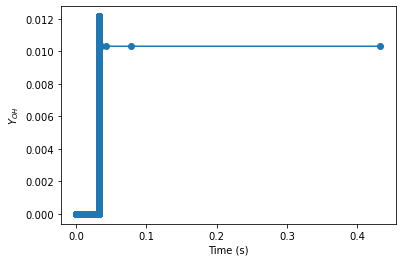

In [35]:
fig, ax = plt.subplots()
ax.plot(time_history.t, time_history(reference_species).Y, "-o")
ax.set_xlabel("Time (s)")
ax.set_ylabel("$Y_{OH}$");

## Illustration : NTC behavior

A common benchmark for a reaction mechanism is its ability to reproduce the **N**egative **T**emperature **C**oefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

Typical NTC behavior for n-heptane occurs from ~600-800 K, so we need to do an integration of the problem at temperatures in a wide range around those temperatures. We can use some functions from NumPy to make it easy to generate the temperatures we want.

In [36]:
T = np.hstack((np.arange(1800, 1000, -100), np.arange(1000, 475, -25)))

As before, we will define some estimated ignition delay times to limit the integration time. These are chosen empirically and must be updated for different fuels or different conditions.

In [37]:
estimated_ignition_delay_times = np.ones_like(T, dtype=float)

estimated_ignition_delay_times[:6] = 0.1
estimated_ignition_delay_times[-4:-2] = 10
estimated_ignition_delay_times[-2:] = 100

And last, we will create a `SolutionArray` to store the ignition delay results. This `SolutionArray` will only store the final result of calculating the ignition delay, not the time history of each simulation. In this case, we know that we want to have as many rows as the `T` array in our `SolutionArray`, so we can initialize it that way. Then we can set the initial conditions for the entire array of `Solution`s!

In [38]:
ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau":estimated_ignition_delay_times})
ignition_delays.set_equivalence_ratio(1.0, fuel="nc7h16", oxidizer={"o2": 1.0,"n2": 3.76})
ignition_delays.TP = T, reactor_pressure

Now, we can loop through these states and use them to set the state of the `gas` object, which we can use in the `IdealGasReactor` and do the integration again.

This time, we'll only store the information we care about from the simulation, which are the time steps and the history of the reference species. We will use regular Python `list`s to store this information, since they are quite efficient when appending data rapidly.

Then we will compute the ignition delay from this data and proceed to the next state!

In [41]:
for i, state in enumerate(ignition_delays):
    # Setup the gas and reactor
    gas.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])
    reference_species_history = []
    time_history = []
    t = 0
    while t < estimated_ignition_delay_times[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])
    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    print(f"Computed Ignition Delay: {tau:.3e} seconds for T={state.T:.0f} K.")
    ignition_delays.tau[i] = tau
print("Calculation complete!")

Computed Ignition Delay: 2.973e-05 seconds for T=1800 K.
Computed Ignition Delay: 3.105e-05 seconds for T=1700 K.
Computed Ignition Delay: 4.090e-05 seconds for T=1600 K.
Computed Ignition Delay: 7.158e-05 seconds for T=1500 K.
Computed Ignition Delay: 1.646e-04 seconds for T=1400 K.
Computed Ignition Delay: 4.748e-04 seconds for T=1300 K.
Computed Ignition Delay: 1.632e-03 seconds for T=1200 K.
Computed Ignition Delay: 6.443e-03 seconds for T=1100 K.
Computed Ignition Delay: 3.248e-02 seconds for T=1000 K.
Computed Ignition Delay: 5.040e-02 seconds for T=975 K.
Computed Ignition Delay: 7.909e-02 seconds for T=950 K.
Computed Ignition Delay: 1.252e-01 seconds for T=925 K.
Computed Ignition Delay: 1.983e-01 seconds for T=900 K.
Computed Ignition Delay: 3.057e-01 seconds for T=875 K.
Computed Ignition Delay: 4.266e-01 seconds for T=850 K.
Computed Ignition Delay: 4.726e-01 seconds for T=825 K.
Computed Ignition Delay: 3.795e-01 seconds for T=800 K.
Computed Ignition Delay: 2.443e-01 seco

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

Last, we will create an Arrhenius plot of the ignition delays.

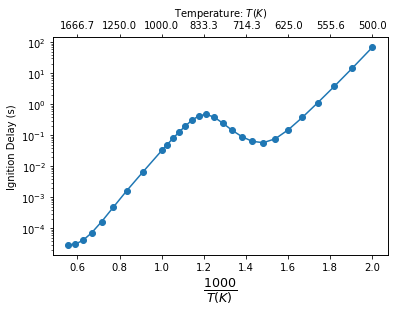

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignition_delays.T, ignition_delays.tau, 'o-')
ax.set_ylabel('Ignition Delay (s)')
ax.set_xlabel(r'$\frac{1000}{T (K)}$', fontsize=18)
# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'Temperature: $T(K)$');